In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Reshape, Dropout, Flatten
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing import sequence

import matplotlib.pyplot as plt


In [2]:
# 생성자 모델 생성

generator = Sequential()
generator.add(Dense(128 * 7 * 7, input_dim=100, activation=LeakyReLU(0.2))) # 노이즈 이미지 생성
generator.add(BatchNormalization())                                         # 데이터의 정규화 작업 : 분산1, 평균0
generator.add(Reshape((7, 7, 128)))                                         # Conv에 입력 가능한 자료로 변환
generator.add(UpSampling2D())                                               # 이미지 확대 : 14 * 14
generator.add(Conv2D(64, 5, padding='same'))                                # 14 * 14, size 변동 없음 
generator.add(BatchNormalization())                                         # 데이터 정규화
generator.add(Activation(LeakyReLU(0.2)))                                   # 활성화 함수는 LeakyReLU 사용
generator.add(UpSampling2D())                                               # 이미지 확대 28 * 28
generator.add(Conv2D(1, 5, padding='same', activation='tanh'))

In [3]:
# 판별자 모델 생성

discriminator = Sequential()
discriminator.add(Conv2D(64, 5, strides=2, input_shape=(28, 28, 1), padding='same'))    # 28 * 28 * 64
discriminator.add(Activation(LeakyReLU(0.2)))                                           # 활성화 함수 지정
discriminator.add(Dropout(0.3))                                                         # 30% node 꺼줌
discriminator.add(Conv2D(128, 5, strides=2, padding='same'))                            # 28 * 28 * 128
discriminator.add(Activation(LeakyReLU(0.2)))                                           
discriminator.add(Dropout(0.3))                                                         
discriminator.add(Flatten())                                                            # 1차원으로 평탄화
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.trainable = False

In [4]:
# 생성자와 판별자 모델을 연결시키는 gan 모델 생성

ginput = Input(shape=(100,))
dis_output = discriminator(generator(ginput))
gan = Model(ginput, dis_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 28, 28, 1)         865281    
                                                                 
 sequential_1 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


1/1 [==============================] - 0s 59ms/step
epoch:0 d_loss:0.4775 g_loss:0.0433
1/1 [==============================] - 0s 70ms/step
epoch:1 d_loss:0.5073 g_loss:0.0515
1/1 [==============================] - 0s 62ms/step
epoch:2 d_loss:0.4786 g_loss:0.1002
1/1 [==============================] - 0s 60ms/step
epoch:3 d_loss:0.4487 g_loss:0.2152
1/1 [==============================] - 0s 62ms/step
epoch:4 d_loss:0.4457 g_loss:0.3323
1/1 [==============================] - 0s 60ms/step
epoch:5 d_loss:0.4798 g_loss:0.3575
1/1 [==============================] - 0s 53ms/step
epoch:6 d_loss:0.4837 g_loss:0.3370
1/1 [==============================] - 0s 61ms/step
epoch:7 d_loss:0.4641 g_loss:0.2958
1/1 [==============================] - 0s 60ms/step
epoch:8 d_loss:0.4252 g_loss:0.2760
1/1 [==============================] - 0s 65ms/step
epoch:9 d_loss:0.4051 g_loss:0.2877
1/1 [==============================] - 0s 61ms/step
epoch:10 d_loss:0.3780 g_loss:0.2909
1/1 [==========================

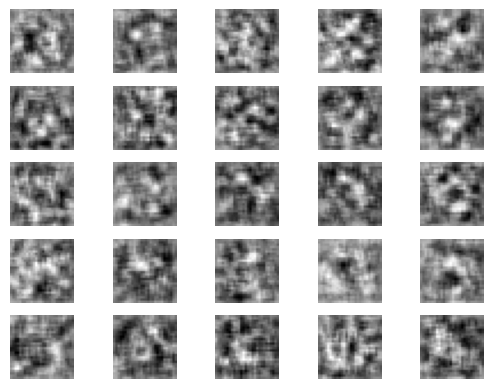

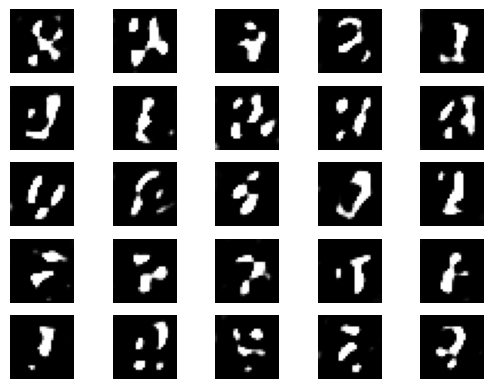

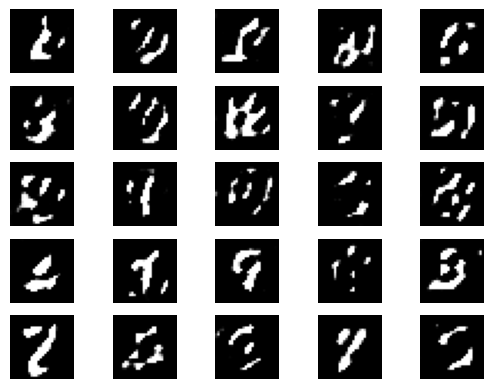

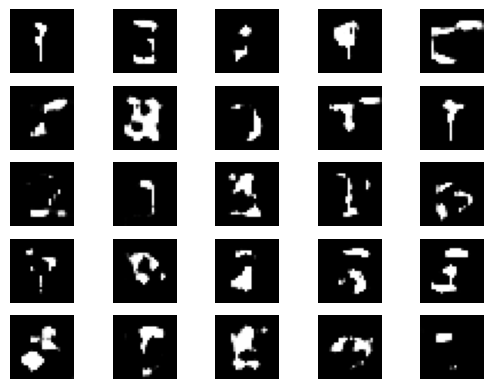

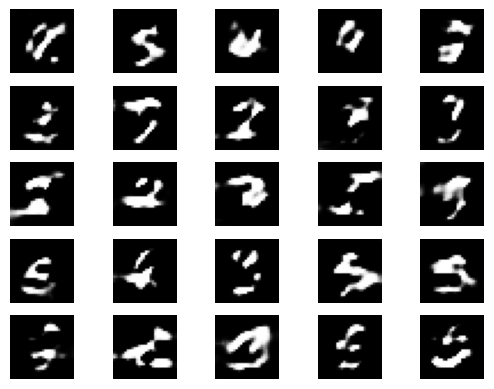

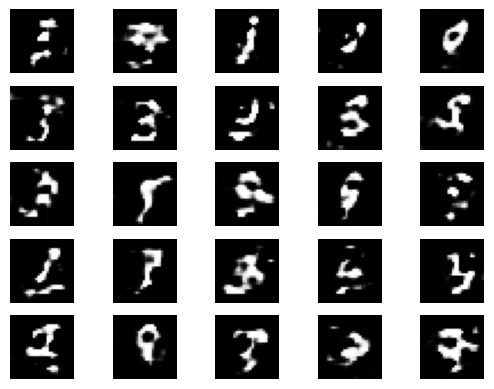

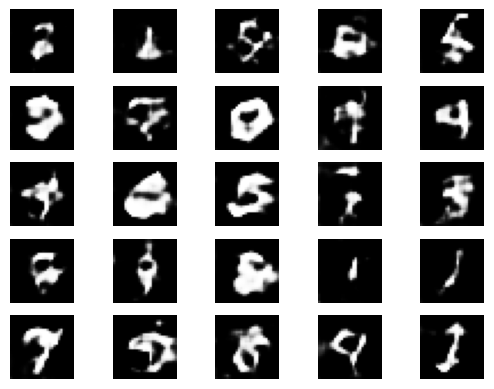

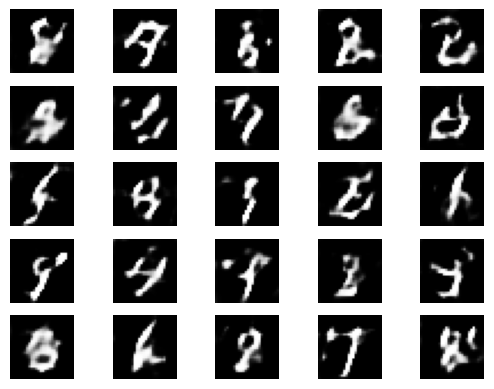

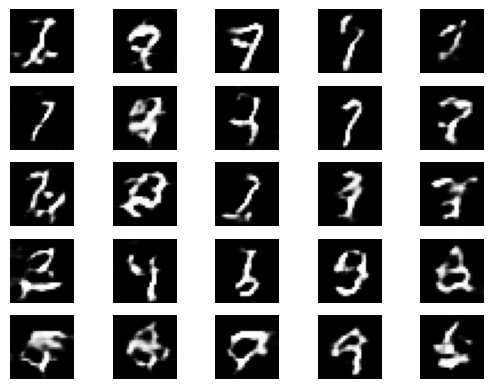

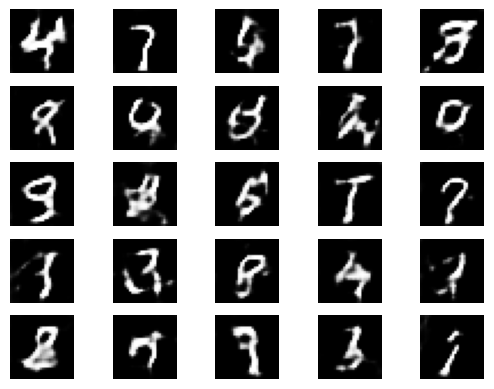

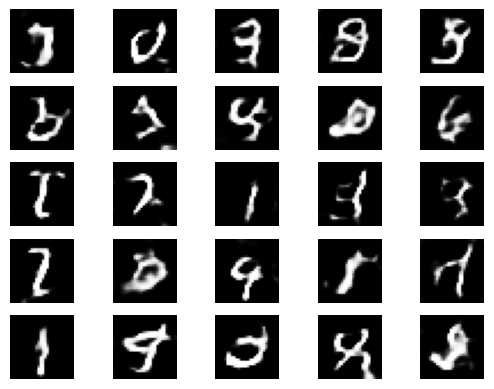

In [10]:
# 신경망을 실행 시키는 함수 생성

def gan_train(epoch, batch_size, saving_interval):
    (X_train, _), (_, _) = mnist.load_data()        # 이미지만 사용하기 때문에 X_train 만 호출
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')    # Conv2D를 사용하기 위해 3차원 배열로 변환
    X_train = (X_train - 127.5) / 127.5
    
    true = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    for i in range(epoch):
        # 실제 데이터를 판별자에 입력하는 부분
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]
        d_loss_real = discriminator.train_on_batch(imgs, true)
        
        # 가상 이미지를 판별자에 입력하는 부분
        noise = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(noise)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        
        # 판별자와 생성자의 오차 계산
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        g_loss = gan.train_on_batch(noise, true)
        
        print('epoch:%d' % i, 'd_loss:%.4f' % d_loss, 'g_loss:%.4f' % g_loss)
        
        # 중간 과정을 이미지러 저장
        # 정해진 인터벌만큼 학습되면 그때 만든 이미지를 gan_image 폴더에 저장
        if i % saving_interval == 0:
            # r, c = 5, 5
            noise = np.random.normal(0, 1, (25, 100))
            gen_imgs = generator.predict(noise)
            
            gen_imgs = 0.5 * gen_imgs + 0.5
            
            fig, axs = plt.subplots(5, 5)
            count = 0
            
            for j in range(5):
                for k in range(5):
                    axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                    axs[j, k].axis('off')
                    count += 1
            fig.savefig('gan_image/gan_mnist_%d.png' % i)
            
# 2000번 반복되고 배치크기는 32, 200번 마다 결과 저장
gan_train(2001, 32, 200)